In [2]:
!pip -q install pillow
!pip -q install ray[tune,train]==2.8.0
!pip -q install hyperopt==0.2.7

**NOTE**: you might need to restart your kernel after you installed the modules 

In [ ]:
from braket.jobs.local.local_job import LocalQuantumJob
from braket.aws import AwsQuantumJob, AwsSession
from braket.jobs.image_uris import Framework, retrieve_image
from braket.jobs.config import InstanceConfig, StoppingCondition

from ray import tune, train
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search import ConcurrencyLimiter
from ray.tune import JupyterNotebookReporter

import boto3
import time
import pathlib
import shutil
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from pathlib import Path
import pandas as pd
import uuid
import json
import datetime
import numpy as np



# Quantum Machine Learning with Transfer Learning

This notebook shows how to train a hybrid classical-quantum image classifier on Braket using transfer learning. The described example is based on the tutorials of Pennylane [Quantum transfer learning](https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning.html) and of PyTorch [Transfer Learning Using Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). The hybrid classical-quantum method for transfer learning is detailed by [Mari et al.(2019)](https://arxiv.org/abs/1912.08278). The classification task is to differentiate images which show either ants or bees.

The following sections focus on the implementation and training of the classifier model on Amazon Braket. Utilizing the [Braket quantum devices](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html) for model training enables training of large quantum neural networks (QNN), which are infeasible to train on a standard local machine. In this notebook a QNN with 18 qubits is trained on Brakets SV1 high-performance state vector simulator and can readily be adjusted to train larger QNNs with a higher number of qubits on SV1 or Braket's real quantum devices.

This notebooks demonstrates how to
- Reduce datasets to make the example more feasible to run on quantum devices.
- Train a hybrid classical-quantum model for computer vision on Braket
- Run the model training with a local simulator and a high-performance simulator
- Explore limitations when training a QNN 
- Test a QNN implementation efficiently

# Requirements

- Running notebook as Amazon Braket notebook with **conda_braket** kernel
- The Python module pillow needs to be installed for previewing image data
- Later in this notebook, a Docker image is pushed to AWS Elastic Container Registry (ECR). This requires an extension of the IAM permissions of the execution role of the notebook.

Follow the next sections to comply to the requirements

## Amazon Braket Notebook

Please find details on how to run a Amazon Braket notebook in the [Get started with Amazon Braket](https://docs.aws.amazon.com/braket/latest/developerguide/braket-get-started.html).

## Permissions of execution role

In [4]:
sts_client = boto3.client("sts")
execution_role = sts_client.get_caller_identity()['Arn'].split('/')[-2]

print(f"The execution role of this notebook is: {execution_role}")


The execution role of this notebook is: AmazonBraketServiceSageMakerNotebookRole-20221124T195954


Create the following IAM policy and attach it to the execution role shown above.

```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "ECRAccess",
            "Effect": "Allow",
            "Action": [
                "ecr:BatchGetImage",
                "ecr:BatchCheckLayerAvailability",
                "ecr:CompleteLayerUpload",
                "ecr:GetDownloadUrlForLayer",
                "ecr:InitiateLayerUpload",
                "ecr:PutImage",
                "ecr:UploadLayerPart",
                "ecr:CreateRepository"
            ],
            "Resource": "arn:aws:ecr:*:<YOUR-ACCOUNT-ID>:repository/amazon-braket-my-qtc"
        }
    ]
}
```

Make sure that you have replaced `<YOUR-ACCOUNT-ID>` with your account ID.

# Setup environment

In [10]:
sess = AwsSession()
region = sess.region
role = sess.get_default_jobs_role()
default_bucket = sess.default_bucket()

prefix = "qml"

In [11]:
sts_client = boto3.client("sts")
account_id = sts_client.get_caller_identity()["Account"]

In [ ]:
account_id

# Explore and prepare image data

Image classifiers use the high-dimensional input of images to predict the content of images. Encodig high-dimensional data for quantum machine learning (QML) is particularly challenging on current quantum hardware due to the limited number of qubits. The hybrid classical-quantum transfer learning approach of [Mari et al.(2019)](https://arxiv.org/abs/1912.08278) uses a pretrained classical neural network to extract low-dimensional features which are feed into a QNN. Additionally, using a pretrained classical network allows to train the model on a smaller data set than would be required when training the network from scratch. More details are given in the Pennylane [tutorial](https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning.html).

The notebook uses image data provided by PyTorch to train a classifier to distiguish images showing bees and ants. In the following the data is downloaded to the local `data` folder and a reduced dataset is uploaded to S3.

In [ ]:
%%bash
mkdir -p ./data 
wget -P ./data https://download.pytorch.org/tutorial/hymenoptera_data.zip
cd data && unzip hymenoptera_data.zip

The dataset is reduced to make the example more feasible to run on quantum devices. Using the reduced dataset decreases the models predictive capabilities. However, the focus of this notebook is to demonstrate the implementation conceptually rather than training a model with high predictive power.

In [18]:
data_dir="data/hymenoptera_data"
reduced_data_dir=f"{data_dir}_reduced"

s3_reduced_data_bucket = f"s3://{default_bucket}/{prefix}/data/"

max_number_files = 8

In [19]:
for split in ['train', 'val']:
    for cat in ['bees', 'ants']:
        path_full = os.path.join(data_dir, split, cat)
        path_reduced = os.path.join(reduced_data_dir, split, cat)
        pathlib.Path(path_reduced).mkdir(parents=True, exist_ok=True)
        file_list = [f for f in os.listdir(path_full) if os.path.isfile(os.path.join(path_full,f))]
        for f in file_list[:max_number_files]:
            shutil.copy(os.path.join(path_full, f), os.path.join(path_reduced, f))

In [ ]:
!aws s3 cp {reduced_data_dir} {s3_reduced_data_bucket} --recursive

Here are four example images of each category on which the model is trained.

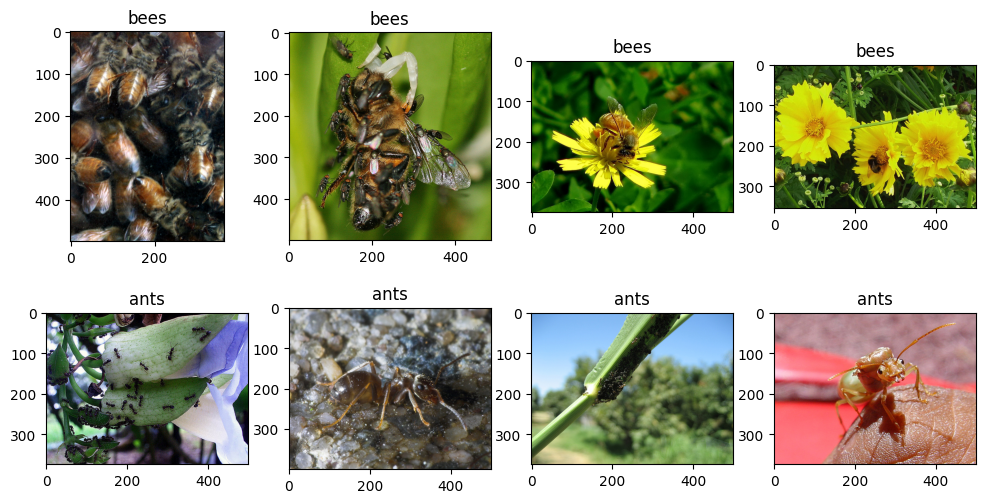

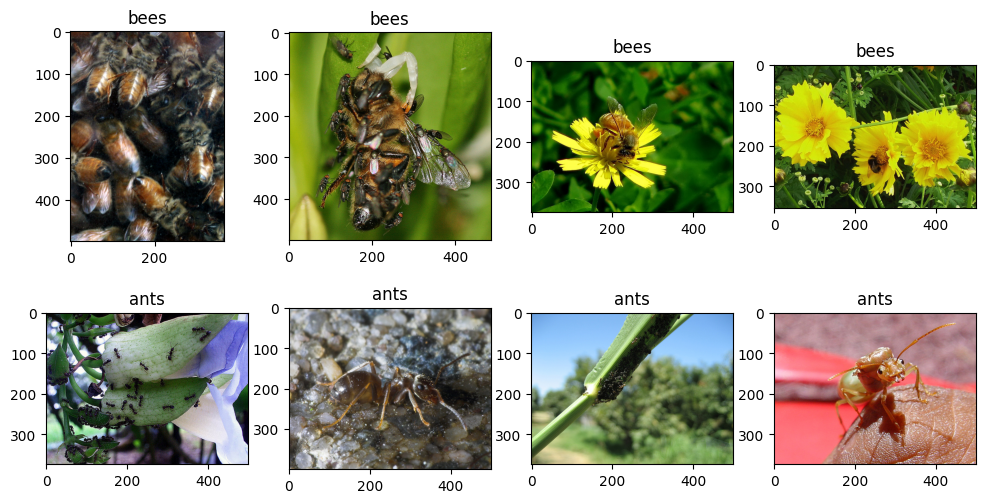

In [17]:
n_images = 4

fig, axs = plt.subplots(2, n_images,figsize=(12,6))

for i, c in enumerate(['bees','ants']):
    files = list(Path(f"./{reduced_data_dir}").rglob(f"{c}/*.jpg"))
    rand_select = random.sample(range(0, len(files)), n_images)

    for j in range(n_images):
        axs[i, j].imshow(mpimg.imread(files[rand_select[j]]))
        axs[i, j].set_title(c)

fig

# Build Cointainer

The quantum transfer learning approach used in this notebook is a hybrid classical-quantum algorithm, i.e. it uses alternatingly classical and quantum compute resources. Quantum compute resources are allocated through a job queue on Amazon Braket. Running a hybrid classical-quantum algorithm from the notebook instance would submit a quantum task to the queue on every classical-quantum iteration, and hence will lead to a potentially high walltime caused by accumulated queueing times. For avoiding high walltime the hybrid algorithm can be submitted as a [Amazon Braket hybrid job](https://aws.amazon.com/blogs/aws/introducing-amazon-braket-hybrid-jobs-set-up-monitor-and-efficiently-run-hybrid-quantum-classical-workloads/), which will give associated quantum tasks high priority once the job has started. 

In a Amazon Braket job the training code is executed in a container environment. Amazon Braket offers [prebuilt docker containers](https://github.com/aws/amazon-braket-containers) among others for QML with PyTorch which is used in this notebook. However, the pre-buit PyTorch container does not have the module torchvision installed, and hence, a custom container is used here. Setting up a custom container is also described in more detail [here](https://github.com/aws/amazon-braket-examples/tree/main/examples/hybrid_jobs/3_Bring_your_own_container).

A Dockerfile defines the environment the training script will run in. Here a prebuilt Amazon Braket PyTorch image is used as a baseline and the Python module torchvision is added to it.

In [21]:
%%writefile Dockerfile
FROM 292282985366.dkr.ecr.us-east-1.amazonaws.com/amazon-braket-pytorch-jobs:1.8.1-cpu-py37-ubuntu18.04

RUN python3 -m pip install --upgrade pip
RUN python3 -m pip install amazon-braket-sdk==1.35.5 --upgrade
RUN python3 -m pip install torchvision==0.10.1

Writing Dockerfile


To make the custom container available to Amazon Braket, an container image is created and stored in a repository of AWS Elastic Container Registry (ECR). The default Amazon Braket jobs have access to repositories starting with `amazon-braket`. For different names the poliy of the default role needs to be adjusted.

In [22]:
# create ECR
ecr_repository_name = "amazon-braket-my-qtc"
image_uri_byoc=f"{account_id}.dkr.ecr.{region}.amazonaws.com/{ecr_repository_name}:latest"

In [ ]:
!aws ecr create-repository --repository-name {ecr_repository_name} --region {region}

In [27]:
!docker login -u AWS -p $(aws ecr get-login-password --region us-east-1) 292282985366.dkr.ecr.us-east-1.amazonaws.com
!docker login -u AWS -p $(aws ecr get-login-password --region {region}) {account_id}.dkr.ecr.{region}.amazonaws.com

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


Let's build the custom Docker image defined by the Dockerfile and push it to the ECR repository. This makes the image ready to be used by Amazon Braket.

In [ ]:
!docker build -t dockerfile .

In [29]:
!docker tag dockerfile:latest {account_id}.dkr.ecr.{region}.amazonaws.com/{ecr_repository_name}:latest

In [ ]:
!docker push {account_id}.dkr.ecr.{region}.amazonaws.com/{ecr_repository_name}:latest

# Model Script

The model definition, the training method and evaluation are defined in the script `model_script.py`. The QML core code is based on the Pennylane tutorial [Quantum transfer learning](https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning.html) and described there in great detail. The code is adopted here to be submittable as a Amazon Braket job.

The architecture employs a classical neural network for feature extraction and a quatum neural network for classification resulting in a hybrid classical-quantum algorithm. The width and depth of the quantum neural network is defined by the hyperparameters `n_qubits` and `q_depth`, respectively. The classical neural network is defined as [ResNet18](https://arxiv.org/abs/1512.03385) architecture and weights are pretrained on ImageNet. 

In [31]:
script_path= f"{os.getcwd()}/model_script.py"

In [32]:
%%writefile {script_path}


import time
import os
import copy
import itertools
import subprocess
import json
import logging
import random

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Braket
from braket.jobs import load_job_checkpoint, save_job_checkpoint, save_job_result
from braket.jobs.metrics import log_metric
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
random.seed(4)

class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self, dev, device, n_qubits, q_delta, q_depth, noise, param_noise ):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.n_qubits = n_qubits
        self.q_delta = q_delta
        self.q_depth = q_depth
        self.noise = noise
        self.param_noise = param_noise
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)
        self.dev = dev
        self.device = device

                
    def bitflip_layer(self, nqubits, p):
        """Layer of single-qubit bit flip operations.
            p = probability for bit flip
        """
        for idx in range(nqubits):
            qml.BitFlip(p, wires=idx)

    def depolarizing_layer(self, nqubits, p):
        """Layer of single-qubit depolarizing channel.
            p = probability of depolarization
        """
        for idx in range(nqubits):
            qml.DepolarizingChannel(p, wires=idx)

    def gate_noise_layer_1Q(self, nqubits, param_noise):
        """Single qubit gate noise applied to all qubits
        """
        # first we apply a bit flip error
        
        p_bitflip = float(param_noise["p_bitflip_1Q"])
        if p_bitflip > 0:
            self.bitflip_layer(nqubits, p_bitflip)
            
        # second the depolarizing channel 
        p_depol = float(param_noise["p_depolarizer_1Q"])
        if p_depol > 0:
            self.depolarizing_layer(nqubits, p_depol)
            
    def gate_noise_layer_2Q(self, qubit_wires, param_noise):
        """Two qubit gate noise applied to all qubits
        """
        # first we apply a bit flip error
        
        p_bitflip = float(param_noise["p_bitflip_2Q"])
        if p_bitflip > 0:
            self.bitflip_layer(nqubits, p_bitflip)
            
        # second the depolarizing channel 
        p_depol = float(param_noise["p_depolarizer_2Q"])
        if p_depol > 0:
            self.depolarizing_layer(nqubits, p_depol)

    def H_layer(self, nqubits, noise, param_noise):
        """Layer of single-qubit Hadamard gates.
        """
        for idx in range(nqubits):
            qml.Hadamard(wires=idx)
        if noise:
            self.gate_noise_layer_1Q(nqubits, param_noise)

    def RY_layer(self, w, nqubits, noise, param_noise):
        """Layer of parametrized qubit rotations around the y axis.
        """
        for idx, element in enumerate(w):
            qml.RY(element, wires=idx)
        if noise:
            self.gate_noise_layer_1Q(nqubits, param_noise)

    def entangling_layer(self, nqubits, noise, param_noise):
        """Layer of CNOTs followed by another shifted layer of CNOT.
        """
        # In other words it should apply something like :
        # CNOT  CNOT  CNOT  CNOT...  CNOT
        #   CNOT  CNOT  CNOT...  CNOT
        
        if noise:
            p_bitflip = float(param_noise["p_bitflip_2Q"])
            p_depol = float(param_noise["p_depolarizer_2Q"])            
        
        for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
            qml.CNOT(wires=[i, i + 1])
            if noise:
                qml.BitFlip(p_bitflip, wires=i)
                qml.BitFlip(p_bitflip, wires= i + 1)
                qml.DepolarizingChannel(p_depol, wires=i)
                qml.DepolarizingChannel(p_depol, wires=i+1)
                
        for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
            qml.CNOT(wires=[i, i + 1])
            if noise:
                qml.BitFlip(p_bitflip, wires=i)
                qml.BitFlip(p_bitflip, wires= i + 1)
                qml.DepolarizingChannel(p_depol, wires=i)
                qml.DepolarizingChannel(p_depol, wires=i+1)
            
    def quantum_net(self, q_input_features, q_weights_flat, q_depth, n_qubits, noise, param_noise):
        @qml.qnode(self.dev, interface="torch")
        def _quantum_net(q_input_features, q_weights_flat, q_depth, n_qubits, noise, param_noise):
            """
            The variational quantum circuit.
            """
            #print("start QC")
            # Reshape weights
            q_weights = q_weights_flat.reshape(q_depth, n_qubits)

            # Start from state |+> , unbiased w.r.t. |0> and |1>
            self.H_layer(n_qubits, noise, param_noise)
            
            # Embed features in the quantum node
            self.RY_layer(q_input_features, n_qubits, noise, param_noise)
            
            # Sequence of trainable variational layers
            for k in range(q_depth):
                self.entangling_layer(n_qubits, noise, param_noise)

                self.RY_layer(q_weights[k], n_qubits, noise, param_noise)
                

            # Expectation values in the Z basis
            exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
            return tuple(exp_vals)
        return _quantum_net(q_input_features, q_weights_flat, q_depth, n_qubits, noise, param_noise)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, self.n_qubits)
        q_out = q_out.to(self.device)
        for elem in q_in:
            q_out_elem = self.quantum_net(
                elem, 
                self.q_params, 
                self.q_depth, 
                self.n_qubits,
                self.noise,
                self.param_noise).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

def _train_model(model, image_datasets, criterion, optimizer, scheduler, batch_size, num_epochs, device):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    
    dataloaders = {
        x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
        for x in ["train", "validation"]
    }
    dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
    
    logger.info("Training started:")

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size + 1
            
            it = 0
            for inputs, labels in dataloaders[phase]:
   
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches - 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    logger.info("Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    logger.info("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    
    metrics = {
        'train' : {
            'best_loss': best_loss_train,
            'best_acc': best_acc_train,
        },
        'validation' : {
            'best_loss': best_loss,
            'best_acc': best_acc,
        },
        'training_seconds': time_elapsed
    }
    
    return (model, metrics)    

def _save_model(model, model_dir):
    path = os.path.join(model_dir, "model.pth")
    torch.save(model.cpu().state_dict(), path)
    logger.info("PyTorch model saved.")
    
def _get_model(dev, device, n_qubits, q_delta, q_depth, noise, param_noise):
    # create hybrid model
    model_hybrid = torchvision.models.resnet18(pretrained=True)


    for param in model_hybrid.parameters():
        param.requires_grad = False

    # Notice that model_hybrid.fc is the last layer of ResNet18
    model_hybrid.fc = DressedQuantumNet(dev, device, n_qubits, q_delta, q_depth, noise, param_noise)
    
    return model_hybrid
        
def main():
    
    #start cost tracker
    tracker = Tracker().start()
    
    # print environment variables
    logger.info("=== environment variables ==")
    logger.info(os.environ)
    
    input_dir = os.environ["AMZN_BRAKET_INPUT_DIR"]
    output_dir = os.environ["AMZN_BRAKET_JOB_RESULTS_DIR"]
    job_name = os.environ["AMZN_BRAKET_JOB_NAME"]  # noqa
    checkpoint_dir = os.environ["AMZN_BRAKET_CHECKPOINT_DIR"]  # noqa
    hp_file = os.environ["AMZN_BRAKET_HP_FILE"]
    device_arn = os.environ["AMZN_BRAKET_DEVICE_ARN"]
    
    # Read the hyperparameters
    logger.info("=== hyperparameters ===")
    with open(hp_file, "r") as f:
        hyperparams = json.load(f)
    logger.info(hyperparams)
    
    n_qubits = int(hyperparams["n_qubits"])
    n_shots = int(hyperparams["n_shots"])
    step = float(hyperparams["step"])
    batch_size = int(hyperparams["batch_size"])
    num_epochs = int(hyperparams["num_epochs"])
    q_depth = int(hyperparams["q_depth"])
    gamma_lr_scheduler = float(hyperparams["gamma_lr_scheduler"])
    q_delta = float(hyperparams["q_delta"])
    max_parallel = int(hyperparams["max_parallel"])
    use_local_simulator = hyperparams["use_local_simulator"]
    noise = hyperparams["simulate_noise"]
    param_noise = {"p_bitflip_1Q": float(hyperparams["p_bitflip_1Q"]), 
                   "p_depolarizer_1Q":  float(hyperparams["p_depolarizer_1Q"]),
                   "p_bitflip_2Q": float(hyperparams["p_bitflip_2Q"]), 
                   "p_depolarizer_2Q":  float(hyperparams["p_depolarizer_2Q"])
                  }
    
    if isinstance(use_local_simulator, str):
        use_local_simulator = (use_local_simulator == 'True')
        
    if isinstance(noise, str):
        noise = (noise == 'True')

    if noise:
        logger.info(f"Simulation with noise: {param_noise}")
    
    # Quantum Setup
    if use_local_simulator:
        if not noise:
            dev = qml.device("default.qubit", wires=n_qubits)
            logger.info("Using local state vector quantum simulator: default.qubit")
        else:
            dev = qml.device("default.mixed", wires=n_qubits)
            logger.info("Using local density matrix quantum simulator: default.mixed")
    else:
        dev = qml.device(
            "braket.aws.qubit",
            device_arn=device_arn,
            wires=n_qubits,
            shots=n_shots,
            s3_destination_folder=None,
            parallel=True,
            max_parallel=max_parallel,
        )
        logger.info(f"Using braket device: {device_arn}")

    # local CPU or GPU device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # data
    data_dir=f"{input_dir}/input"
    logger.info("=== data ===")
    logger.info(os.listdir(data_dir))
    
   
    data_transforms = {
        "train": transforms.Compose(
            [
                # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
                # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                # Normalize input channels using mean values and standard deviations of ImageNet.
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        ),
        "val": transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        ),
    }

    image_datasets = {
        x if x == "train" else "validation": datasets.ImageFolder(
            os.path.join(data_dir, x), data_transforms[x]
        )
        for x in ["train", "val"]
    }
    
    metrics = {}
    
    try:
    
        # get hybrid model
        model_hybrid = _get_model(dev, device, n_qubits, q_delta, q_depth, noise, param_noise)

        # Use CUDA or CPU according to the "device" object.
        model_hybrid = model_hybrid.to(device)

        criterion = nn.CrossEntropyLoss()

        optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

        exp_lr_scheduler = lr_scheduler.StepLR(
            optimizer_hybrid, 
            step_size=10, 
            gamma=gamma_lr_scheduler
        )
        
        model_hybrid, metrics = _train_model(
            model_hybrid, 
            image_datasets,
            criterion, 
            optimizer_hybrid, 
            exp_lr_scheduler, 
            batch_size=batch_size,
            num_epochs=num_epochs,
            device=device
        )
        _save_model(model_hybrid, output_dir)

    except Exception as e:
        logger.error(e)
        
    finally:
        tracker_output = {}
        tracker_output['quantum_tasks_statistics'] = tracker.quantum_tasks_statistics()
        tracker_output['qpu_tasks_cost'] = tracker.qpu_tasks_cost()
        tracker_output['simulator_tasks_cost'] = tracker.simulator_tasks_cost()

        logger.info("Quantum Task Summary")
        logger.info(tracker_output['quantum_tasks_statistics'])
        logger.info('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
        logger.info(f"Estimated cost to run this example: {tracker_output['qpu_tasks_cost'] + tracker_output['simulator_tasks_cost']:.2f} USD")

        # save results
        save_job_result({'metrics': metrics, 'hyperparams': hyperparams, 'tracker': tracker_output})

if __name__ == "__main__":
    main()


Writing /home/ec2-user/SageMaker/hpo-for-qml/model_script.py


Before submitting, the script is compiled to check the syntax. The syntax is correct if the compilation does not throw any error.

In [33]:
!python -m py_compile {script_path}

# Model Training and Evaluation

The model is trained in three different ways

| Approach | CPU | Quantum | Purpose
| --- | --- | --- | ---
| Local execution | notebook instance | local simulator | Testing
| Amazon Braket job with HPO on TM1 | remote instance | TM1 simulator | Find best hyperparameters
| Amazon Braket job with QPU | remote instance | QPU | Verify results found for best hyperparameters


## Local Execution

The model training and evaluation is carried out with `LocalQuantumJob`, which pull the custom image from ECR and executes the container on the notebook instance. The `LocalQuantumJob` requires a `device_arn` to be passed as an input. To avoid execution of quantum computation on the device specified by the `device_arn`, the hyperparmeter `use_local_simulator` can be set to True.

The local execution is used for fast testing of the model script and for initial manual hyperparameter optimization. A very small dataset is used in this notebook to avoid high wall times when calculating QNNs with high number of qubits. This comes at the cost of high dependency of model quality on hyperparameters and random initializations. The later is adressed by fixed random seeds in the model script to allow for reproducability of this demonstration.

In [34]:
hyperparameters_local = {
    "n_qubits": 4,                # Number of qubits
    "n_shots": 25,                # Number of measurements
    "step": 0.0006,               # Learning rate
    "batch_size": 2,              # Number of samples for each training step
    "num_epochs": 1,              # Number of training epochs
    "q_depth": 2,                 # Depth of the quantum circuit (number of variational layers)
    "gamma_lr_scheduler": 0.1,    # Learning rate reduction applied every 10 epochs.
    "q_delta": 0.01,              # Initial spread of random quantum weights
    "max_parallel": 50,           # Number of concurrent task (not used for local simulator)
    "use_local_simulator": True,  # Run quantum computation on simulator rather than on Braket quantum devices
    "simulate_noise": True,       # Apply noise to quantum circuit 
    "p_bitflip_1Q": 0,            # Noise channel 1: bitflip probability of single qubit gate
    "p_depolarizer_1Q": 0.01,     # Noise channel 2: depolarizing probability of single qubit gate
    "p_bitflip_2Q": 0,            # Noise channel 1: bitflip probability of two qubit gate
    "p_depolarizer_2Q": 0.09,     # Noise channel 2: depolarizing probability of two qubit gate
}

In [ ]:
job_name = f"qml-local-job-{int(time.time())}"

job = LocalQuantumJob.create(
    device='local',
    source_module=script_path,
    job_name=job_name,
    image_uri=image_uri_byoc,
    hyperparameters=hyperparameters_local,
    input_data=s3_reduced_data_bucket,
    aws_session=sess,
)

## Amazon Braket Hybrid Job with Hyperparameter Optimization on TM1

In this section we run multiple hybrid jobs concurrently to explore a hyperparameter space. We limit concurrent execution to three to avoid hitting the [Amazon Braket quota](https://docs.aws.amazon.com/braket/latest/developerguide/braket-quotas.html) for creating quantum tasks, which defaults to 20 quantum tasks per second in this account per Region. If you want to increase concurrent execution, you can request a quota increase for your account.

In [36]:
# hyperparameters and search space
hyperparameters_quantum_job = hyperparameters_local.copy()
hyperparameters_quantum_job["use_local_simulator"] = False

search_space= { 
    "n_qubits": tune.randint(4, 13),
    "q_depth": tune.randint(1, 4),
    "batch_size": tune.randint(2, 6),
    "step": tune.uniform(0.0001, 0.001),
}

# q_device = "arn:aws:braket:::device/quantum-simulator/amazon/sv1" # no noise
q_device = "arn:aws:braket:::device/quantum-simulator/amazon/dm1" # with noise (need density matrix simulater): 

job_instance_type = "ml.m5.large"

In [38]:
def run_quantum_job(config, wait_until_complete=True):

    # adjust hyperparameters
    hyperparameters = hyperparameters_quantum_job.copy()

    for k in config.keys():
        if k in hyperparameters.keys():
            hyperparameters[k] = str(config[k])
        else:
            raise ValueError(f'Could not find parameter: {k}')

    job_name = f"{prefix}-{str(uuid.uuid4().hex)[:24]}"

    job = AwsQuantumJob.create(
        device=q_device,
        source_module=script_path,
        job_name=job_name,
        instance_config=InstanceConfig(instanceType=job_instance_type),
        image_uri=image_uri_byoc,
        copy_checkpoints_from_job=None,
        hyperparameters=hyperparameters,
        input_data=s3_reduced_data_bucket,
        wait_until_complete=wait_until_complete,
    )


    if job.state() == 'COMPLETED':
        job_result = job.result()
        print(job_result)

        # persist tarcker results to job output dir
        with open(f"braket_tracker_{job_name}.json", "w") as f:
            json.dump(job_result['tracker'], f)

        if 'validation' in job_result['metrics'].keys():
            best_loss = job_result['metrics']['validation']['best_loss']
        else:
            best_loss = np.nan

        return {'validation_loss': best_loss}

    if not wait_until_complete:
        # return job in case of async execution for further job tracking
        return job

    else:
        # return NaN if not async execution and not status COMPLETED
        return {'validation_loss': np.nan}

In [ ]:
# ray parameters
ray_storage_path = os.getcwd() + "/ray_tuner_results"

search_alg = HyperOptSearch(
    n_initial_points=5,
    mode='min',
    metric='validation_loss',
    random_state_seed=42,
)

search_alg = ConcurrencyLimiter(
    search_alg,
    max_concurrent=3,
)

reporter = JupyterNotebookReporter()
reporter.add_metric_column("validation_loss")

tuner = tune.Tuner(run_quantum_job,
                   param_space=search_space,
                   tune_config=tune.TuneConfig(
                       num_samples=8,
                       search_alg=search_alg),
                   run_config=train.RunConfig(
                       storage_path=ray_storage_path,
                       progress_reporter=reporter,
                       name=f"qml-{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"),
                  )

results = tuner.fit()

(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluster]
(run_quantum_job pid=18592) . [repeated 2x across cluste

### Get best result and configuration

In [ ]:
hpo_best_score = results.get_best_result(metric="validation_loss", mode="min").metrics['validation_loss']
hpo_best_hyperparameters = results.get_best_result(metric="validation_loss", mode="min").config
hpo_best_result_path = results.get_best_result(metric="validation_loss", mode="min").path

print(f"Best validation loss achieved: {hpo_best_score}")
print(f"Best config: {hpo_best_hyperparameters}")


### Costs of HPO trials
The costs for each hybrid job are tracked with Amazon Braket Cost Tracker, and results are stored in the Ray results folder of the trial. Below the estimated costs and job statistics are pulled and displayed for the best HPO configuration.

In [ ]:
def get_tracker_data(r_path):
    t_file = [f for f in os.listdir(r_path) if f.startswith('braket_tracker_')][0]

    with open(os.path.join(r_path, t_file), 'r') as f:
        t_data = json.loads(f.read())

    return t_data

In [ ]:
print(f"Tracker results for best trial in path: {hpo_best_result_path}")
tracker_data_best_result = get_tracker_data(hpo_best_result_path)
print(json.dumps(tracker_data_best_result, indent=2))
print("---")
print(f"Estimated costs: {tracker_data_best_result['simulator_tasks_cost']} USD")

As shown above, calculating the trial with the lowest validation loss incurred estimated costs of 1.32 USD. Furthermore, it required 8800 shots and 352 tasks on DM1 simulator. These statistics are used in the next sections for cost estimation to run the best configuration on a Braket QPU.

**NOTE**: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2)

**NOTE**: Due to random noise in the calculations, the best performing configuration might change, and hence, the cost estimation might change.

In [ ]:
parent_result_path, _ = os.path.split(hpo_best_result_path)

estimated_costs_hpo = {}
for path in [d for d in os.listdir(parent_result_path) if os.path.isdir(os.path.join(parent_result_path, d))]:
    t_data = get_tracker_data(os.path.join(parent_result_path, path))
    estimated_costs_hpo[path] = t_data['simulator_tasks_cost']

print(json.dumps(estimated_costs_hpo, indent=2))
print("---")
print(f"Estimated costs for HPO trials: {sum(estimated_costs_hpo.values())} USD")


## Verification on Braket QPU

To verify the results found as part of the HPO, the hybrid job is submitted with a Braket QPU as quantum device. The job as defined for the SV1 simulator is ready to be run on an actual quantum device. To switch to another Amazon Braket device, only the parameter `q_device` needs to be set to the ARN of the desired device. Furthermore, the simulated noise is deacticated, since the calculation will include the real noise from the QPU.


**NOTE**: If you run a job with a Braket QPU for the first time you'll an error message that you need to accept the user agreement. Follow the provided link to proceed.

## Cost Estimation

The below cell executes the QML algorithm with the hyperparameter found by the HPO above. The quantum task statistics, i.e. shots and tasks, required to compute the QML algorithm for these parameters were also presented above. In our example, 8800 shots and 352 tasks were executed. **Please note**, the number of shots and tasks migth vary with each execution of the notebook.

Based on the number of shots and tasks, we can leverage [Braket Pricing](https://aws.amazon.com/braket/pricing/) to estimate the costs for running the algorithm on a Braket QPU. For example, assuming costs per task of 0.3 USD and per shot of 0.00035 USD will sum up to 108.68 USD for using the quantum device only.


## Execution

In [37]:
hyperparameters_quantum_job = hyperparameters_local.copy()
hyperparameters_quantum_job["use_local_simulator"] = False
hyperparameters_quantum_job["simulate_noise"] = False

q_device = 'arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy'


In [38]:
# Setting the best HPO parameters statically for reproducability.
# Comment code in this cell to ensure to use HPO result from above.
hpo_best_hyperparameters = {
    'n_qubits': 5,
    'q_depth': 1,
    'batch_size': 3,
    'step': 0.0009197231855706787
}

In [ ]:
# The following lines will execute the QML algorithm on a Braket QPU, which will involve costs for the QPU. 
# The job is started asynchronously
# umcomment following lines to execute the job on a Braket QPU
#quantum_job = run_quantum_job(hpo_best_hyperparameters, wait_until_complete=False)
#print(quantum_job)

In [46]:
# checking state of hybrid job
while quantum_job.state() != 'COMPLETED':
    job_state = quantum_job.state()
    print(f"hybrid job state: {job_state}")
    time.sleep(30)

job_results = quantum_job.result()

print(f"Validation loss: {job_results['metrics']['validation']['best_loss']}")
print('---')
print(job_results['tracker']['quantum_tasks_statistics'])
print(f"Estimated cost to run this example: {job_results['tracker']['qpu_tasks_cost'] + job_results['tracker']['simulator_tasks_cost']:.2f} USD")

Validation loss: 0.6337597668170929
---
{'arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy': {'shots': 8800, 'tasks': {'COMPLETED': 352}}}
Estimated cost to run this example: 108.68 USD


We get a validation loss of around 0.63 from the calculation on the Braket QPU, which is fairly aligned with the validation loss 0.67 which we got from our best configuration of the HPO calculated on DM1 simualtor. In terms of costs, the estimated costs of the Braket QPU match our estimation from above.